# Outlier Detection (Gaussian Toy Example)

In this notebook, we will demonstrate the basics of outlier detection in the context of anomaly detection. 
We will use simple Gaussian toy data to demonstrate the basic concepts. 

In the outlier detection version of anomaly detection, we train a model to learn what our background looks like
and then classify things as anomalous based on how 'disimilar' they look as compared to the background. 

Essentially this means we are defining events that have low probability density under the background to be anomalous. 
In this case, we are generating our own Gaussian toy data, so we know the true probability distribution of the background.
However, in realistic physics examples this is usually not the case. 
One must therefore train a machine learning model to learn the background probability distribution, or an equivalent proxy, from a sample of background events.

One common proxy used to learn the background distribution is a type of neural network called an autoencoder.
Autoencoders do not directly learn the probability distribution. Instead they are trained to take the input data, compress it down into some smaller representation
and decompress it back out to recover the original inputs. The idea is that by forcing the model to learn to compress the data, it will force it to learn its underlying structure.
If the model is trained only on background events, it should hopefully learn how to do this compression task for background events but not for signal events.
Therefore, there should be a larger difference between the model input and output on signal events. 
This difference, called the reconstruction loss, can therefore be used as an anomaly score.

Note that unlike weak supervision, we expect this type model to always be worse than a supervised classifier because it never sees signal events during the training.
However, it can usuaully be trained in an easier fashion, (because one only needs to find a sample of background events) and has a stable performance instead of varying depending on the amount of signal present. 

In [1]:
import numpy as np
import scipy
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from os.path import exists, join, dirname, realpath


# adding parent directory to path
parent_dir = dirname(realpath(globals()["_dh"][0]))
sys.path.append(parent_dir)

from sk_cathode.classifier_models.autoencoder import Autoencoder
from sk_cathode.classifier_models.neural_network_classifier import NeuralNetworkClassifier

In [2]:
#Pick the dimensionality of our dataset
n_dim = 10 #How many total dimensions of our data
n_signal_dim = 2 #How many dimensions of our signal are different from background


#Background is multi-dim Gaussian with zero mean, diagonal covariance of one
bkg_means = np.array([0.]*n_dim)
bkg_vars = np.ones(n_dim)
bkg_cov = np.diag(bkg_vars)
bkg_pdf = scipy.stats.multivariate_normal(bkg_means, bkg_cov)


#Signal is multi-dim Gaussian centered at 1 for 'signal like dimensions and 0 for the bkg-like dimensions
sig_means = np.array([2.5]*n_signal_dim + [0.] *(n_dim - n_signal_dim) )
sig_vars = np.array(n_signal_dim * [0.1] + [1.0]* (n_dim - n_signal_dim))
sig_cov = np.diag(sig_vars)
sig_pdf = scipy.stats.multivariate_normal(sig_means, sig_cov)

verbose = 0


In [3]:
#Data for training of autoencoder classifer
n_bkg = 100000
bkg_events_train = bkg_pdf.rvs(size = n_bkg )


#Data for training of supervised classifer
n_sup = 10000
sig_events_sup = sig_pdf.rvs(size = n_sup)
bkg_events_sup = bkg_pdf.rvs(size = n_sup)

x_sup = np.append(sig_events_sup, bkg_events_sup, axis = 0)
y_sup = np.append(np.ones(n_sup, dtype = np.int8), np.zeros(n_sup, dtype =np.int8))

x_sup, y_sup = shuffle(x_sup, y_sup, random_state = 42)
x_sup_train, x_sup_val, y_sup_train, y_sup_val = train_test_split(x_sup, y_sup, test_size = 0.2, random_state = 42)

#Data for testing
n_test = 50000
sig_events_test = sig_pdf.rvs(size = n_test//10)
bkg_events_test = bkg_pdf.rvs(size = n_test)

x_test = np.append(sig_events_test, bkg_events_test, axis = 0)
y_test = np.append(np.ones(n_test//10, dtype = np.int8), np.zeros(n_test, dtype =np.int8))



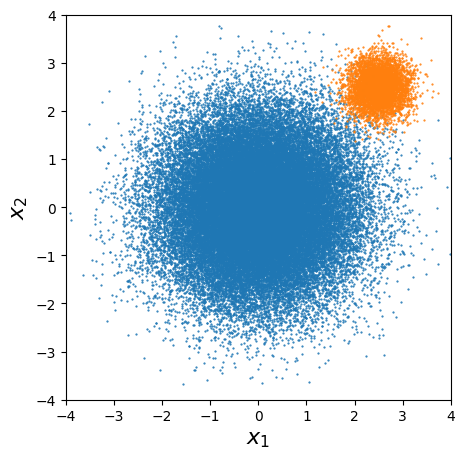

In [4]:
# Simple scatter plot of the first two dimensions of our data, background is in blue, signal is in orange
plt.figure(figsize = (5,5))
plt.scatter(bkg_events_test[:,0],bkg_events_test[:,1],s=0.3,color='C0')
plt.scatter(sig_events_test[:,0],sig_events_test[:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.xlabel(r'$x_1$',fontsize=16)
plt.ylabel(r'$x_2$',fontsize=16)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()


In [12]:
#AE model

#Pick size of compressed representation (latent)
latent_size = 4
layers = [n_dim, 32, 16, latent_size, 16, 32, n_dim]

AE_model = Autoencoder(n_inputs=n_dim, layers = layers, val_split = 0.1,
                    early_stopping=True, epochs=100, verbose=True)
AE_model.fit(bkg_events_train)


Epoch: 0


Train loss: 0.722056: 100%|██████████| 100000/100000 [00:02<00:00, 45266.35it/s]


Validation loss: 0.5970344698185202

Epoch: 1


Train loss: 0.585792: 100%|██████████| 100000/100000 [00:02<00:00, 45542.20it/s]


Validation loss: 0.5760517759091409

Epoch: 2


Train loss: 0.564075: 100%|██████████| 100000/100000 [00:02<00:00, 45533.65it/s]


Validation loss: 0.5476310773350089

Epoch: 3


Train loss: 0.524111: 100%|██████████| 100000/100000 [00:02<00:00, 44474.95it/s]


Validation loss: 0.4942797537121322

Epoch: 4


Train loss: 0.475232: 100%|██████████| 100000/100000 [00:02<00:00, 46251.15it/s]


Validation loss: 0.459886339466895

Epoch: 5


Train loss: 0.453486: 100%|██████████| 100000/100000 [00:02<00:00, 48901.68it/s]


Validation loss: 0.4467747306351162

Epoch: 6


Train loss: 0.441631: 100%|██████████| 100000/100000 [00:01<00:00, 52046.33it/s]


Validation loss: 0.4383053908034054

Epoch: 7


Train loss: 0.434719: 100%|██████████| 100000/100000 [00:02<00:00, 46951.10it/s]


Validation loss: 0.43141321235757957

Epoch: 8


Train loss: 0.430523: 100%|██████████| 100000/100000 [00:02<00:00, 45477.72it/s]


Validation loss: 0.4303247762076995

Epoch: 9


Train loss: 0.426772: 100%|██████████| 100000/100000 [00:02<00:00, 43086.28it/s]


Validation loss: 0.42673329143877836

Epoch: 10


Train loss: 0.424750: 100%|██████████| 100000/100000 [00:02<00:00, 45133.30it/s]


Validation loss: 0.4236639500274073

Epoch: 11


Train loss: 0.423287: 100%|██████████| 100000/100000 [00:02<00:00, 45982.20it/s]


Validation loss: 0.42274003386345055

Epoch: 12


Train loss: 0.422408: 100%|██████████| 100000/100000 [00:02<00:00, 46732.53it/s]


Validation loss: 0.42083599145912454

Epoch: 13


Train loss: 0.420868: 100%|██████████| 100000/100000 [00:02<00:00, 48021.92it/s]


Validation loss: 0.4231969139841207

Epoch: 14


Train loss: 0.419620: 100%|██████████| 100000/100000 [00:02<00:00, 42073.92it/s]


Validation loss: 0.41894964157315473

Epoch: 15


Train loss: 0.418617: 100%|██████████| 100000/100000 [00:02<00:00, 44387.24it/s]


Validation loss: 0.4181050149071247

Epoch: 16


Train loss: 0.418252: 100%|██████████| 100000/100000 [00:02<00:00, 42590.59it/s]


Validation loss: 0.41748814193336553

Epoch: 17


Train loss: 0.417608: 100%|██████████| 100000/100000 [00:02<00:00, 48180.56it/s]


Validation loss: 0.41752308069744987

Epoch: 18


Train loss: 0.416667: 100%|██████████| 100000/100000 [00:01<00:00, 51632.92it/s]


Validation loss: 0.4168434787513045

Epoch: 19


Train loss: 0.416603: 100%|██████████| 100000/100000 [00:02<00:00, 47418.96it/s]


Validation loss: 0.4153266054818697

Epoch: 20


Train loss: 0.416242: 100%|██████████| 100000/100000 [00:02<00:00, 47550.82it/s]


Validation loss: 0.42054345151957345

Epoch: 21


Train loss: 0.415756: 100%|██████████| 100000/100000 [00:02<00:00, 46516.48it/s]


Validation loss: 0.415750872334251

Epoch: 22


Train loss: 0.415416: 100%|██████████| 100000/100000 [00:02<00:00, 45877.63it/s]


Validation loss: 0.4139751566721655

Epoch: 23


Train loss: 0.414868: 100%|██████████| 100000/100000 [00:02<00:00, 48000.05it/s]


Validation loss: 0.4142252241101716

Epoch: 24


Train loss: 0.414643: 100%|██████████| 100000/100000 [00:02<00:00, 43826.98it/s]


Validation loss: 0.41541871714317585

Epoch: 25


Train loss: 0.415157: 100%|██████████| 100000/100000 [00:02<00:00, 43092.98it/s]


Validation loss: 0.4134691469657147

Epoch: 26


Train loss: 0.415025: 100%|██████████| 100000/100000 [00:02<00:00, 43075.49it/s]


Validation loss: 0.4158110996646345

Epoch: 27


Train loss: 0.414674: 100%|██████████| 100000/100000 [00:02<00:00, 45377.97it/s]


Validation loss: 0.4133591636672349

Epoch: 28


Train loss: 0.414875: 100%|██████████| 100000/100000 [00:02<00:00, 44194.42it/s]


Validation loss: 0.4156788808991537

Epoch: 29


Train loss: 0.415016: 100%|██████████| 100000/100000 [00:02<00:00, 42634.59it/s]


Validation loss: 0.41525956416678855

Epoch: 30


Train loss: 0.414570: 100%|██████████| 100000/100000 [00:02<00:00, 46683.17it/s]


Validation loss: 0.4185175917794942

Epoch: 31


Train loss: 0.414696: 100%|██████████| 100000/100000 [00:02<00:00, 43735.62it/s]


Validation loss: 0.414517977353557

Epoch: 32


Train loss: 0.414627: 100%|██████████| 100000/100000 [00:02<00:00, 44957.18it/s]


Validation loss: 0.41254851210605153

Epoch: 33


Train loss: 0.413628: 100%|██████████| 100000/100000 [00:02<00:00, 42947.05it/s]


Validation loss: 0.4151501428821813

Epoch: 34


Train loss: 0.414012: 100%|██████████| 100000/100000 [00:02<00:00, 45694.76it/s]


Validation loss: 0.4155456485498287

Epoch: 35


Train loss: 0.413595: 100%|██████████| 100000/100000 [00:02<00:00, 46125.93it/s]


Validation loss: 0.4178670800631613

Epoch: 36


Train loss: 0.413619: 100%|██████████| 100000/100000 [00:02<00:00, 46920.55it/s]


Validation loss: 0.41325560787602156

Epoch: 37


Train loss: 0.413367: 100%|██████████| 100000/100000 [00:01<00:00, 52022.07it/s]


Validation loss: 0.4130214330028085

Epoch: 38


Train loss: 0.413210: 100%|██████████| 100000/100000 [00:01<00:00, 51965.03it/s]


Validation loss: 0.4133343491179254

Epoch: 39


Train loss: 0.413135: 100%|██████████| 100000/100000 [00:01<00:00, 51208.51it/s]


Validation loss: 0.4129247214559399

Epoch: 40


Train loss: 0.413242: 100%|██████████| 100000/100000 [00:01<00:00, 52787.19it/s]


Validation loss: 0.4131026597279112

Epoch: 41


Train loss: 0.413371: 100%|██████████| 100000/100000 [00:01<00:00, 51224.87it/s]


Validation loss: 0.41408286363724855

Epoch: 42


Train loss: 0.413116: 100%|██████████| 100000/100000 [00:02<00:00, 42942.98it/s]


Validation loss: 0.41164061057445644

Epoch: 43


Train loss: 0.412741: 100%|██████████| 100000/100000 [00:01<00:00, 50218.89it/s]


Validation loss: 0.4133417036222375

Epoch: 44


Train loss: 0.412927: 100%|██████████| 100000/100000 [00:02<00:00, 47856.91it/s]


Validation loss: 0.41270263512116256

Epoch: 45


Train loss: 0.413110: 100%|██████████| 100000/100000 [00:01<00:00, 50909.14it/s]


Validation loss: 0.41311388632373125

Epoch: 46


Train loss: 0.412796: 100%|██████████| 100000/100000 [00:01<00:00, 50678.33it/s]


Validation loss: 0.41232088067190115

Epoch: 47


Train loss: 0.413124: 100%|██████████| 100000/100000 [00:01<00:00, 50351.65it/s]


Validation loss: 0.4141158626969818

Epoch: 48


Train loss: 0.413872: 100%|██████████| 100000/100000 [00:01<00:00, 52957.57it/s]


Validation loss: 0.41352966919427026

Epoch: 49


Train loss: 0.414032: 100%|██████████| 100000/100000 [00:01<00:00, 51680.86it/s]


Validation loss: 0.41361235676671537

Epoch: 50


Train loss: 0.413377: 100%|██████████| 100000/100000 [00:01<00:00, 50233.65it/s]


Validation loss: 0.4158485084391006

Epoch: 51


Train loss: 0.413482: 100%|██████████| 100000/100000 [00:02<00:00, 49472.11it/s]


Validation loss: 0.4141078574578171

Epoch: 52


Train loss: 0.413068: 100%|██████████| 100000/100000 [00:02<00:00, 49782.36it/s]


Validation loss: 0.41414423313592097
Early stopping at epoch 52


AttributeError: 'Autoencoder' object has no attribute 'layers'

AttributeError: 'Autoencoder' object has no attribute 'layers'

AttributeError: 'Autoencoder' object has no attribute 'layers'

In [13]:
#Do a quick check of the performance of the autoencoder as a classifier 
x_test_pred = AE_model.predict(x_test)
#MSE loss gives 'anomaly score' for each event 
y_test_AE = np.sum((x_test_pred - x_test)**2, axis = -1)
auc_AE = roc_auc_score(y_test, y_test_AE)

print("AE AUC %.3F" % auc_AE)

AE AUC 0.917


In [14]:
#Do a quick check of the performance of the true bkg pdf as a classifier 
x_test_pdf = bkg_pdf.pdf(x_test)
#One over bkg probability as outlier score 
y_test_pdf = 1./x_test_pdf

auc_pdf = roc_auc_score(y_test, y_test_pdf)
print("bkg PDF AUC %.3F" % auc_pdf)

bkg PDF AUC 0.951


In [8]:
#Train a supervised model for comparison

sup_model = NeuralNetworkClassifier(n_inputs=n_dim,
                                                   early_stopping=True, epochs=100,
                                                   verbose=True)
sup_model.fit(x_sup_train, y_sup_train, x_sup_val, y_sup_val)


Epoch: 0


Train loss: 0.179009: 100%|██████████| 16000/16000 [00:00<00:00, 35864.75it/s]


Validation loss: 0.029879058653023094

Epoch: 1


Train loss: 0.027541: 100%|██████████| 16000/16000 [00:00<00:00, 47386.84it/s]


Validation loss: 0.020614042696252

Epoch: 2


Train loss: 0.020623: 100%|██████████| 16000/16000 [00:00<00:00, 47048.15it/s]


Validation loss: 0.016687150789948646

Epoch: 3


Train loss: 0.016498: 100%|██████████| 16000/16000 [00:00<00:00, 47451.94it/s]


Validation loss: 0.01354926898056874

Epoch: 4


Train loss: 0.014164: 100%|██████████| 16000/16000 [00:00<00:00, 50014.21it/s]


Validation loss: 0.01364397059660405

Epoch: 5


Train loss: 0.012789: 100%|██████████| 16000/16000 [00:00<00:00, 49618.86it/s]


Validation loss: 0.01164714088645269

Epoch: 6


Train loss: 0.012488: 100%|██████████| 16000/16000 [00:00<00:00, 49718.85it/s]


Validation loss: 0.011927165189263178

Epoch: 7


Train loss: 0.010976: 100%|██████████| 16000/16000 [00:00<00:00, 49999.68it/s]


Validation loss: 0.014483887382084504

Epoch: 8


Train loss: 0.011221: 100%|██████████| 16000/16000 [00:00<00:00, 49892.73it/s]


Validation loss: 0.010618302574584959

Epoch: 9


Train loss: 0.010109: 100%|██████████| 16000/16000 [00:00<00:00, 49483.82it/s]


Validation loss: 0.01401844852080103

Epoch: 10


Train loss: 0.010176: 100%|██████████| 16000/16000 [00:00<00:00, 49415.24it/s]


Validation loss: 0.015093459961008193

Epoch: 11


Train loss: 0.009623: 100%|██████████| 16000/16000 [00:00<00:00, 52213.01it/s]


Validation loss: 0.009913743955621612

Epoch: 12


Train loss: 0.009298: 100%|██████████| 16000/16000 [00:00<00:00, 49334.31it/s]


Validation loss: 0.010904874554398702

Epoch: 13


Train loss: 0.008361: 100%|██████████| 16000/16000 [00:00<00:00, 52194.62it/s]


Validation loss: 0.010848513678865856

Epoch: 14


Train loss: 0.009465: 100%|██████████| 16000/16000 [00:00<00:00, 56718.68it/s]


Validation loss: 0.012271680036064936

Epoch: 15


Train loss: 0.008652: 100%|██████████| 16000/16000 [00:00<00:00, 57026.28it/s]


Validation loss: 0.011969451212280546

Epoch: 16


Train loss: 0.008019: 100%|██████████| 16000/16000 [00:00<00:00, 53734.42it/s]


Validation loss: 0.011121533147161244

Epoch: 17


Train loss: 0.007554: 100%|██████████| 16000/16000 [00:00<00:00, 51784.05it/s]


Validation loss: 0.011008295151441416

Epoch: 18


Train loss: 0.007109: 100%|██████████| 16000/16000 [00:00<00:00, 51618.39it/s]


Validation loss: 0.010477033309143735

Epoch: 19


Train loss: 0.007677: 100%|██████████| 16000/16000 [00:00<00:00, 49067.27it/s]


Validation loss: 0.011567147248570109

Epoch: 20


Train loss: 0.007419: 100%|██████████| 16000/16000 [00:00<00:00, 51853.59it/s]


Validation loss: 0.011843961246995605

Epoch: 21


Train loss: 0.006991: 100%|██████████| 16000/16000 [00:00<00:00, 50440.38it/s]


Validation loss: 0.013121031674927508
Early stopping at epoch 21


AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'layers'

In [9]:
#Do a quick check of the performance of the supervised classifier 
y_test_sup = sup_model.predict(x_test)
auc_sup = roc_auc_score(y_test, y_test_sup)

print("Supervised AUC %.3F" % auc_sup)

Supervised AUC 1.000


In [15]:
def make_roc_plot(y_pred, y_true, colors = None, logy = True, labels = None, fname = ""):

    fs = 18
    fs_leg = 16
    sic_max = 10.
    
    sics = []
    tprs = []
    fprs = []

    for idx in range(len(y_pred)):
        fpr, tpr, thresholds = roc_curve(y_true, y_pred[idx])
    
        auc_ = roc_auc_score(y_true, y_pred[idx])

        #guard against division by 0
        fpr = np.clip(fpr, 1e-8, 1.)
        fprs.append(fpr)
        sics.append( tpr / np.sqrt(fpr))
        tprs.append(tpr)

        lbl = 'auc %.3f' % auc_
        clr = 'navy'
        if(labels is not None): labels[idx] = labels[idx] + ", auc=%.3f" % auc_
        if(colors is not None): clr = colors[idx]

        print(lbl)

        

    #ROC plot
    plt.figure(figsize=(10,10))
    for i in range(len(fprs)):
        plt.plot(tprs[i], 1./fprs[i], lw=2, color=colors[i], label=labels[i])
        
    plt.xlim([0, 1.0])
    plt.xlabel('Signal Efficiency', fontsize=fs) 
    plt.yscale('log')
    plt.ylim([1., 1e4])
    plt.ylabel('Bkg Rejection Rate (1/ Bkg. Eff)', fontsize=fs)
    plt.legend(loc="upper right", fontsize = fs_leg)

   
    #SIC plot
    plt.figure(figsize=(10,10))
    for i in range(len(fprs)):
        plt.plot(fprs[i], sics[i], lw=2, color=colors[i], label=labels[i])

    
    plt.xlim([0, 1.0])
    plt.xlabel('Bkg Efficiency', fontsize=fs)
    plt.ylim([0., sic_max])
    plt.ylabel('Significance Improvement (SIC)', fontsize=fs)
    plt.legend(loc="upper right", fontsize = fs_leg)

        



auc 1.000
auc 0.917
auc 0.951


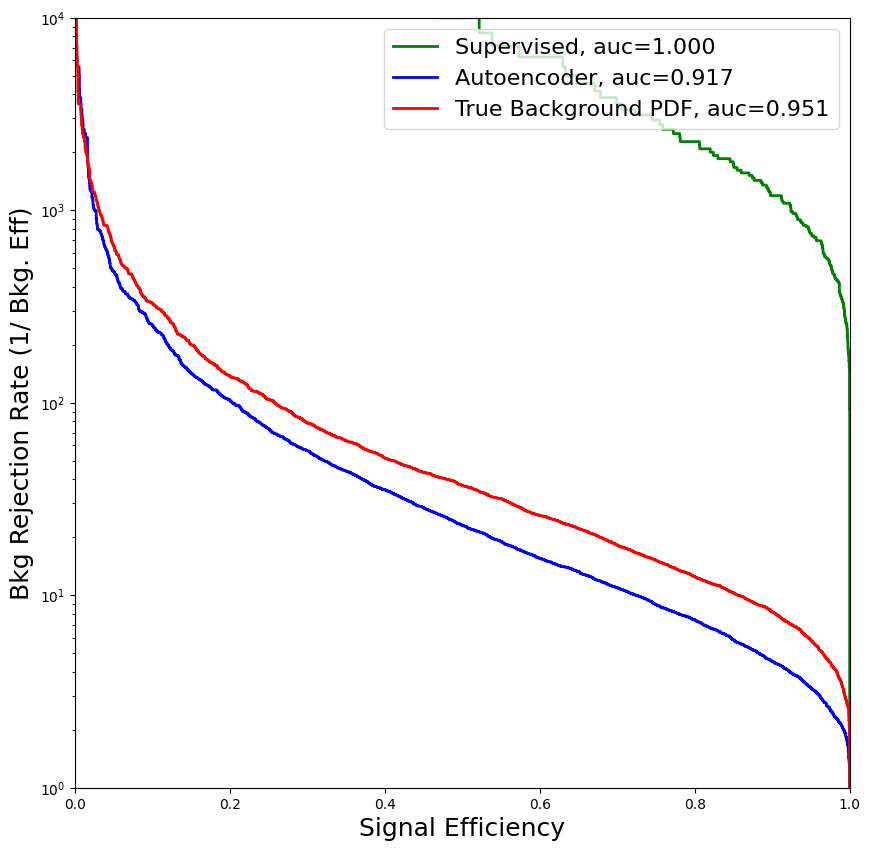

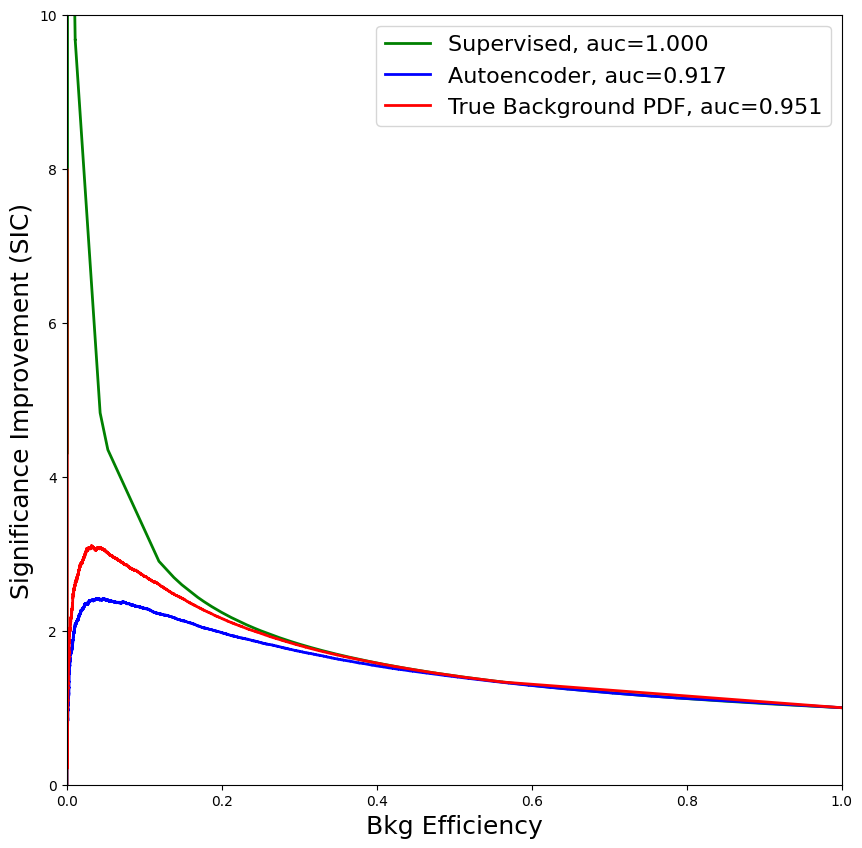

In [16]:
make_roc_plot([y_test_sup, y_test_AE, y_test_pdf], y_test, colors = ['green', 'blue', 'red'], 
              labels = ['Supervised', 'Autoencoder',  'True Background PDF'])
plt.show()